In [41]:
import numpy as np 
import pandas as pd
import vrplib
import collections
from scipy.cluster.hierarchy import linkage, fcluster,inconsistent
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt


In [42]:
# read VRPLIB formatted instances (default)

instance = vrplib.read_instance("C:/Users/cevat/Desktop/assignment/CVRP-Heuristics-Lab/Vrp-Set-D/Vrp-Set-D/D/ORTEC-n242-k12.vrp")
solution = vrplib.read_solution("C:/Users/cevat/Desktop/assignment/CVRP-Heuristics-Lab/Vrp-Set-D/Vrp-Set-D/D/ORTEC-n242-k12.sol")
instance.keys()

dict_keys(['name', 'comment', 'type', 'dimension', 'edge_weight_type', 'edge_weight_format', 'node_coord_type', 'capacity', 'edge_weight', 'node_coord', 'demand', 'depot'])

In [43]:

### 2-Opt Local Search Function
def apply_2opt(edge_weight, route,max_no_improvement=1500):
    """
    Apply the 2-opt algorithm to improve a given route by reversing segments of the route.
    
    Parameters:
    - edge_weight: A matrix representing the distances between nodes.
    - route: A list representing the sequence of nodes in the route.
    - max_no_improvement: The number of iterations with no improvement before stopping.
    
    Returns:
    - best_route: The improved route after applying 2-opt.
    """
    best_route = route
    best_cost = calculate_route_cost(edge_weight, best_route)
    no_improvement_counter = 0
    
    while no_improvement_counter < max_no_improvement:
        improved = False
        for i in range(1, len(route) - 1):
            for j in range(i + 1, len(route)):
                if j - i == 1:  # Skip consecutive nodes as it would result in no change
                    continue
                
                # Create a new route by reversing the segment between i and j
                new_route = best_route[:i] + best_route[i:j][::-1] + best_route[j:]

                new_cost = calculate_route_cost(edge_weight, new_route)
                
                if new_cost < best_cost:
                    best_route = new_route
                    best_cost = new_cost
                    improved = True
        
        if improved:
            no_improvement_counter = 0  # Reset counter if there was an improvement
        else:
            no_improvement_counter += 1  # Increment counter if no improvement was found
    
    return best_route

def calculate_route_cost(edge_weight, route, include_depot=True):
    cost = 0
    # Include the cost from the depot to the first node if specified
    if include_depot and len(route) > 0:
        cost += edge_weight[0, route[0]]

    # Sum the cost of the route between consecutive nodes
    for i in range(len(route) - 1):
        cost += edge_weight[route[i], route[i + 1]]
    
    # Include the cost of returning to the depot from the last node if specified
    if include_depot and len(route) > 0:
        cost += edge_weight[route[-1], 0]
    
    return cost

In [44]:
def hierarchical_clustering(instance):

    vehicle_capacity = instance["capacity"]
    number_of_nodes = len(instance["node_coord"]) 



    # calculate customers vs depot coordinate differences.
    customers = pd.DataFrame(columns=["Demand","DistanceToDepot","CoordDifferenceX","CoordDifferenceY"])
    for customer in range(1,number_of_nodes):
        coord_diff_x = instance["node_coord"][customer,0] - instance["node_coord"][0,0]
        coord_diff_y = instance["node_coord"][customer,1] - instance["node_coord"][0,1]
        customers.loc[customer, "DistanceToDepot"] = instance["edge_weight"][customer,0]
        customers.loc[customer, "Demand"] = instance["demand"][customer]
        customers.loc[customer, "CoordDifferenceX"] = coord_diff_x
        customers.loc[customer, "CoordDifferenceY"] = coord_diff_y


    # Perform hierarchical clustering on coordinate differences
    coords = customers[["CoordDifferenceX", "CoordDifferenceY"]].values
    distances = pdist(coords)  # Calculate the pairwise distances
    linkage_matrix = linkage(distances, method='ward')  # Perform hierarchical clustering

    # Calculate the inconsistency matrix
    inconsistency_matrix = inconsistent(linkage_matrix)

    max_inconsistency = np.max(inconsistency_matrix[:, 0])
    threshold = max_inconsistency * 0.5 

    # Assign clusters based on the dynamic threshold
    customers["Cluster"] = fcluster(linkage_matrix, threshold, criterion='distance')

    # Sort customers by Cluster, then Demand (descending), DistanceToDepot (ascending)
    sorted_customers = customers.sort_values(by=["Cluster", "DistanceToDepot", "Demand"], ascending=[True, True, False])


    # create initial solution dict

    routes = collections.defaultdict(list)

    candidate_vehicle_cap = vehicle_capacity
    candidate_vehicle_index = 0 
    for i in sorted_customers.index: 
        if candidate_vehicle_cap >= sorted_customers.loc[i,"Demand"]   : 
            routes[candidate_vehicle_index].append(i) 
            candidate_vehicle_cap -= sorted_customers.loc[i,"Demand"]
        else:
            candidate_vehicle_index += 1
            routes[candidate_vehicle_index].append(i)
            candidate_vehicle_cap = vehicle_capacity
            candidate_vehicle_cap -= sorted_customers.loc[i,"Demand"]
    return routes

In [45]:
import numpy as np

def nearest_neighbor(instance):
    n = len(instance["demand"])
    visited = np.zeros(n, dtype=bool)  # Track visited nodes
    routes = {}
    route_index = 0
    depot = 0  # Assuming the depot is at index 0
    
    while not all(visited[1:]):  # Continue until all customers are visited
        current_route = []
        current_load = 0
        current_node = depot
        
        while True:
            nearest_node = None
            nearest_distance = float('inf')
            
            # Find the nearest unvisited customer that can be added without exceeding capacity
            for i in range(1, n):
                if not visited[i] and instance["demand"][i] + current_load <= instance["capacity"]:
                    distance = instance["edge_weight"][current_node][i]
                    if distance < nearest_distance:
                        nearest_distance = distance
                        nearest_node = i
            
            if nearest_node is None:  # No more customers can be added to this route
                break
            
            # Add the nearest customer to the route
            current_route.append(nearest_node)
            current_load += instance["demand"][nearest_node]
            visited[nearest_node] = True
            current_node = nearest_node
        
        routes[route_index] = current_route
        route_index += 1

    
    return routes


In [46]:
import math
import numpy as np

def sweep_algorithm(instance):
    n = len(instance["demand"])
    customers = [(i, instance["node_coord"][i]) for i in range(1, n)]
    
    # Calculate the angle for each customer with respect to the depot
    def angle(customer):
        x, y = customer[1][0] - instance["node_coord"][0][0], customer[1][1] - instance["node_coord"][0][1]
        return math.atan2(y, x)
    
    # Sort customers by angle
    customers.sort(key=angle)
    
    routes = {}
    current_route = []
    current_load = 0
    route_index = 0
    
    for customer in customers:
        demand = instance["demand"][customer[0]]
        if current_load + demand <= instance["capacity"]:
            current_route.append(customer[0])
            current_load += demand
        else:
            routes[route_index] = current_route  # Store the route in the dictionary
            route_index += 1
            current_route = [customer[0]]  # Start a new route
            current_load = demand
    
    if current_route:  # Add the last route if it exists
        routes[route_index] = current_route
    
    return routes



In [47]:
import random

def random_solution(instance):
    n = len(instance["demand"])
    customers = list(range(1, n))
    random.shuffle(customers)
    
    routes = {}
    current_route = []
    current_load = 0
    route_index = 0
    
    # random solution considering vehicle capacity
    for customer in customers:
        demand = instance["demand"][customer]
        if current_load + demand <= instance["capacity"]:
            current_route.append(customer)
            current_load += demand
        else:
            routes[route_index] = current_route
            route_index += 1
            current_route = [customer]
            current_load = demand
    
    if current_route:
        routes[route_index] = current_route
    
    return routes


In [48]:
def nearest_neighbor_with_2opt(instance):
    n = len(instance["demand"])
    visited = np.zeros(n, dtype=bool)  # Track visited nodes
    routes = {}
    route_index = 0
    depot = 0  # Assuming the depot is at index 0
    
    while not all(visited[1:]):  # Continue until all customers are visited
        current_route = []
        current_load = 0
        current_node = depot
        
        while True:
            nearest_node = None
            nearest_distance = float('inf')
            
            # Find the nearest unvisited customer that can be added without exceeding capacity
            for i in range(1, n):
                if not visited[i] and instance["demand"][i] + current_load <= instance["capacity"]:
                    distance = instance["edge_weight"][current_node][i]
                    if distance < nearest_distance:
                        nearest_distance = distance
                        nearest_node = i
            
            if nearest_node is None:  # No more customers can be added to this route
                break
            
            # Add the nearest customer to the route
            current_route.append(nearest_node)
            current_load += instance["demand"][nearest_node]
            visited[nearest_node] = True
            current_node = nearest_node
        

        # Apply 2-opt local search to improve the route
        optimized_route = apply_2opt(instance["edge_weight"], current_route)
        routes[route_index] = optimized_route
        route_index += 1
    
    return routes


In [49]:
def calculate_costs(solution, instance, penalty_per_unit):
    total_weight_cost = 0 
    total_weight_cost_with_penalty = 0
    route_cost = collections.Counter()
    total_demand = collections.Counter()

    for vehicle, route in solution.items():
        if len(route) > 0:
            # Cost from depot to the first node
            route_cost[vehicle] += instance["edge_weight"][0, route[0]]

            # Sum the cost of the route between consecutive nodes
            for i in range(len(route) - 1):
                from_node = route[i]
                to_node = route[i + 1]
                route_cost[vehicle] += instance["edge_weight"][from_node, to_node]
            
            # Include the cost of returning to the depot from the last node
            route_cost[vehicle] += instance["edge_weight"][route[-1], 0]

        # Calculate the total demand for the route
        for node in route:
            total_demand[vehicle] += instance["demand"][node]

        total_weight_cost += route_cost[vehicle]
        total_weight_cost_with_penalty += route_cost[vehicle]

        # Apply penalty if the route exceeds the vehicle's capacity
        if total_demand[vehicle] > instance["capacity"]:
            overcapacity = total_demand[vehicle] - instance["capacity"]
            total_weight_cost_with_penalty += penalty_per_unit * overcapacity
    
    return total_weight_cost, total_weight_cost_with_penalty, dict(route_cost), dict(total_demand)


In [50]:
def visualize_routes(instance, solution, title):
    depot = instance["node_coord"][0]
    customer_coords = instance["node_coord"][1:]
    
    plt.figure(figsize=(10, 8))
    
    # Plot depot
    plt.scatter(depot[0], depot[1], color='red', marker='s', s=100, label='Depot')
    
    # Plot customers
    for idx, coord in enumerate(customer_coords, start=1):
        plt.scatter(coord[0], coord[1], color='blue')
    
    # Plot routes
    colors = ['green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black']
    for vehicle, route in solution.items():
        route_coords = [instance["node_coord"][node] for node in route]
        x_coords, y_coords = zip(*route_coords)
        plt.plot(x_coords, y_coords, color=colors[vehicle % len(colors)], linestyle='-', marker='o', label=f'Vehicle {vehicle+1}')
    
    plt.title(title)
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()


In [51]:


def visualize_cost_comparison(instance, solutions, algorithm_names, penalty_per_unit=100):
    """
    Visualize the cost comparison for different algorithms.

    Parameters:
    - instance: The problem instance containing distance matrix, demands, and node coordinates.
    - solutions: A list of solutions where each solution is a dictionary of routes.
    - algorithm_names: A list of algorithm names corresponding to the solutions.
    - penalty_per_unit: The penalty cost per unit of overcapacity.
    """
    
    # Calculate costs for each solution
    costs_no_penalty = []
    costs_penalty = []
    
    for solution in solutions:
        cost_no_penalty, cost_with_penalty, _, _ = calculate_costs(solution, instance, penalty_per_unit)
        costs_no_penalty.append(cost_no_penalty)
        costs_penalty.append(cost_with_penalty)
    
    # Visualize results
    x = np.arange(len(algorithm_names))
    width = 0.29  # Width of the bars

    # Determine the maximum value to scale the y-axis
    max_value = max(max(costs_no_penalty), max(costs_penalty))
    y_max = 2 * max_value  # Scale y-axis to twice the maximum value



    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, costs_no_penalty, width, label='No Penalty')
    bars2 = ax.bar(x + width/2, costs_penalty, width, label='With Penalty')
    
    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Algorithms')
    ax.set_ylabel('Total Cost')
    ax.set_title('Comparison of Algorithm Performance with and without Penalty')
    ax.set_xticks(x)
    ax.set_xticklabels(algorithm_names)
    ax.legend()

    # Set the y-axis limit to twice the maximum value
    ax.set_ylim(0, y_max)

    # Attach a text label above each bar in *bars1* and *bars2*, displaying its height.
    def autolabel(bars):
        """Attach a text label above each bar in *bars*, displaying its height."""
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(bars1)
    autolabel(bars2)

    fig.tight_layout()
    plt.show()


POOR PERFORMANCE, need to add more heuristics on initializations for better start of search. 

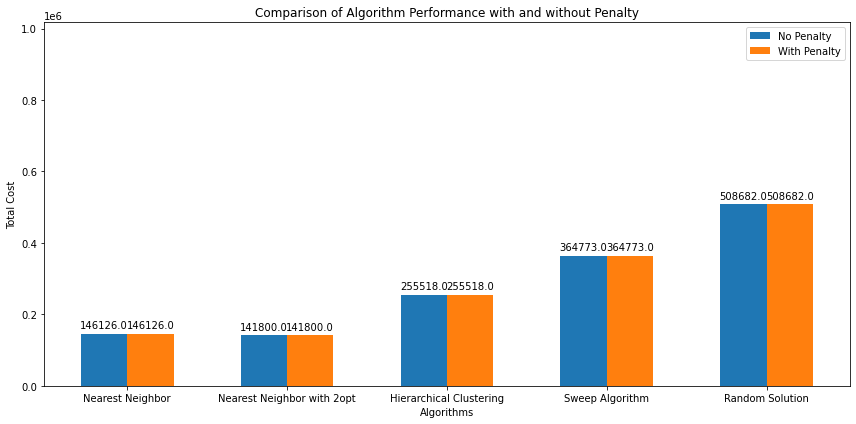

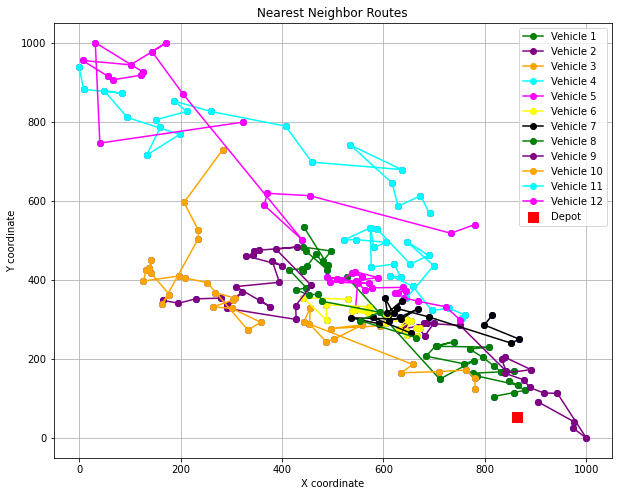

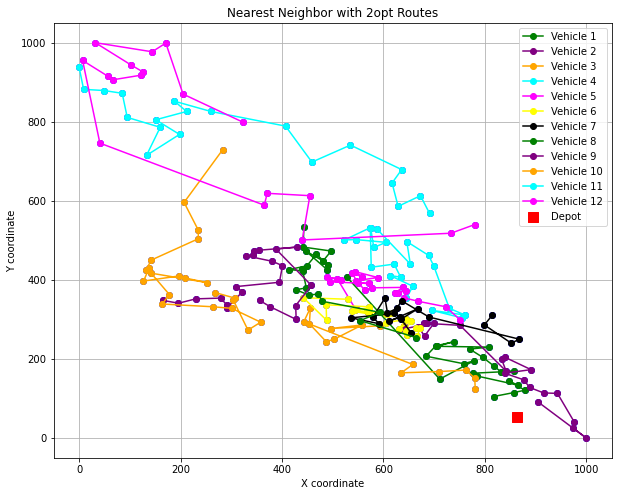

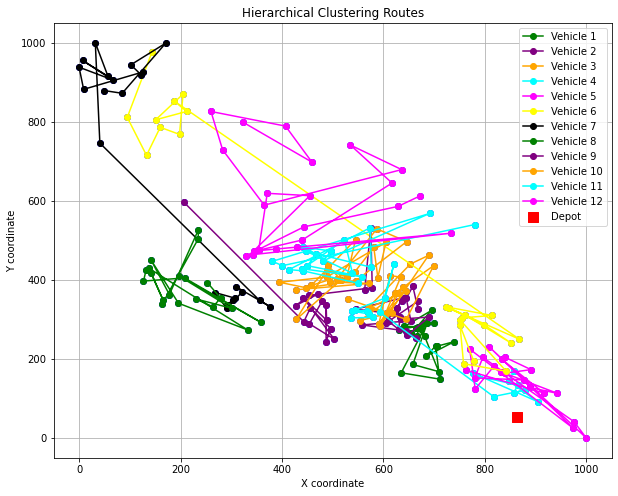

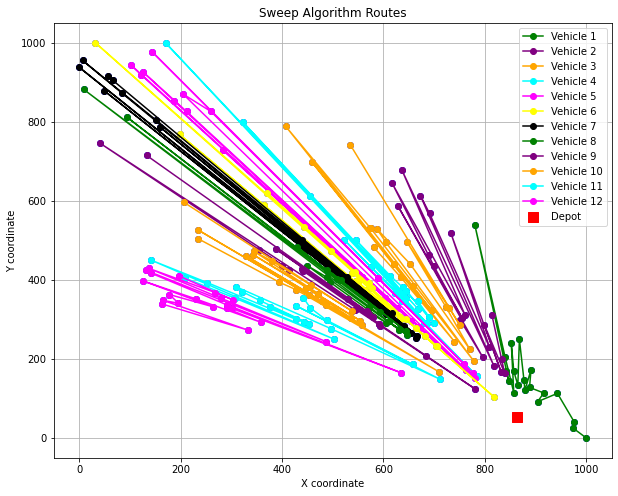

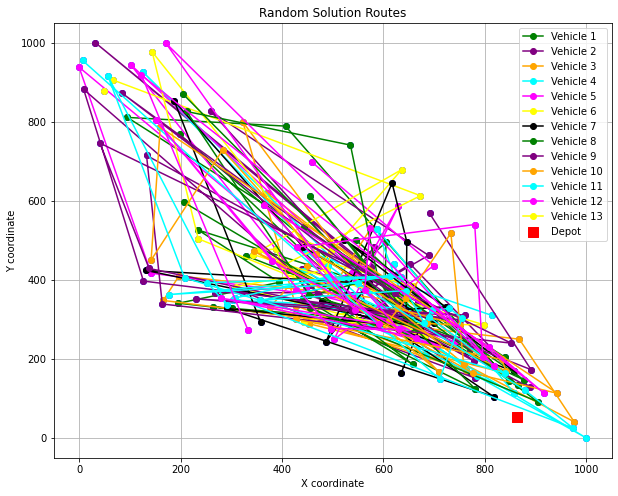

In [52]:
# Generate solutions using different algorithms
routes_nn = nearest_neighbor(instance)
routes_nn_updated = nearest_neighbor_with_2opt(instance)
routes_hc = hierarchical_clustering(instance)
routes_sweep = sweep_algorithm(instance)
random_routes = random_solution(instance)


# Compare the costs of these solutions
solutions = [routes_nn, routes_nn_updated, routes_hc, routes_sweep, random_routes]
algorithm_names = ['Nearest Neighbor','Nearest Neighbor with 2opt', 'Hierarchical Clustering', 'Sweep Algorithm', 'Random Solution']

visualize_cost_comparison(instance, solutions, algorithm_names)

# Visualize routes for each solution
visualize_routes(instance, routes_nn, 'Nearest Neighbor Routes')
visualize_routes(instance, routes_nn_updated, 'Nearest Neighbor with 2opt Routes')
visualize_routes(instance, routes_hc, 'Hierarchical Clustering Routes')
visualize_routes(instance, routes_sweep, 'Sweep Algorithm Routes')
visualize_routes(instance, random_routes, 'Random Solution Routes')